Modification of NuScenes Qualitative.ipynb file to plot forecasts on top of nuScenes map.

In [2]:
%matplotlib inline
import sys
sys.path.append('../../trajectron')
import os
import numpy as np
import torch
import dill
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from helper import *
import visualization

AGENT_COLORS = ['blue', 'green', 'red', 'cyan',
                'magenta', 'yellow', 'orange',
                'dodgerblue', 'coral']


NCOLORS = len(AGENT_COLORS)

In [3]:
# Load nuScenes SDK
nuScenes_data_path = "/home/fireofearth/code/robotics/trajectron-plus-plus/experiments/nuScenes/v1.0"
# Data Path to nuScenes data set
nuScenes_devkit_path = './devkit/python-sdk/'
sys.path.append(nuScenes_devkit_path)
from nuscenes.map_expansion.map_api import NuScenesMap
nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name='boston-seaport')

In [4]:
# Load dataset
with open('../processed/nuScenes_test_full.pkl', 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes

In [5]:
# Load model
ph = 6
log_dir = './models'
model_dir = os.path.join(log_dir, 'int_ee_me')
eval_stg, hyp = load_model(
    model_dir, eval_env, ts=12)


Loading from ./models/int_ee_me/model_registrar-12.pt
Loaded!



### Showing the forecasts

[VEHICLE/ego, VEHICLE/c1932b698eb445fcba4ceb9db6a38556, VEHICLE/e8b0b33be1a647dc8a329d21188fb849, VEHICLE/2b4cd40aad5547629d6f7dab2b6a247b, VEHICLE/be6935a41c3e47bda91e38baf47543c7, VEHICLE/0b99dd853db1493098d9f28e3306c809, VEHICLE/9e8ed3e41ce344f79d6ccc41a689446a]


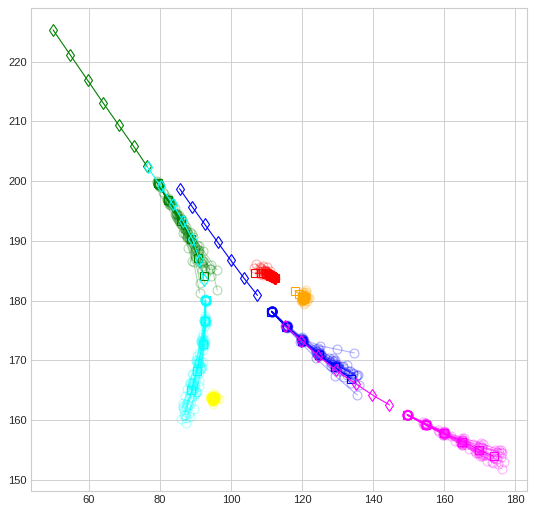

In [6]:
scene = eval_scenes[25]
ph = 6
num_samples=18
t = 6
timesteps = np.array([t])

with torch.no_grad():
    predictions = eval_stg.predict(scene,
            timesteps, ph, num_samples=num_samples,
                z_mode=False,
                gmm_mode=False,
                full_dist=True,
                all_z_sep=False)

prediction_dict, histories_dict, futures_dict = \
    prediction_output_to_trajectories(
        predictions, dt=scene.dt, max_h=10, ph=ph, map=None)

v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[t].keys()))
print(v_nodes)

plt.figure(figsize=(8, 8), dpi=80)
for idx, node in enumerate(v_nodes):
    player_future = futures_dict[t][node]
    player_past = histories_dict[t][node]
    player_predict = prediction_dict[t][node]

    plt.plot(player_future[:,0], player_future[:,1],
                marker='s', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    plt.plot(player_past[:,0], player_past[:,1],
                marker='d', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    for row in player_predict[0]:
        plt.plot(row[:,0], row[:,1],
                marker='o', color=AGENT_COLORS[idx % NCOLORS], alpha=0.3,
                linewidth=1, markersize=8, markerfacecolor='none')

plt.show()

### Showing the map

There are 4 maps:

'boston-seaport'
'singapore-queenstown'
'singapore-onenorth'
'singapore-hollandvillage'

Need to make modifications to Scene class to get location of the forecasts with respect to the map.

https://github.com/StanfordASL/Trajectron-plus-plus/issues/18

Map centered on node VEHICLE/ego


/home/fireofearth/.local/miniconda3/envs/trajectron/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


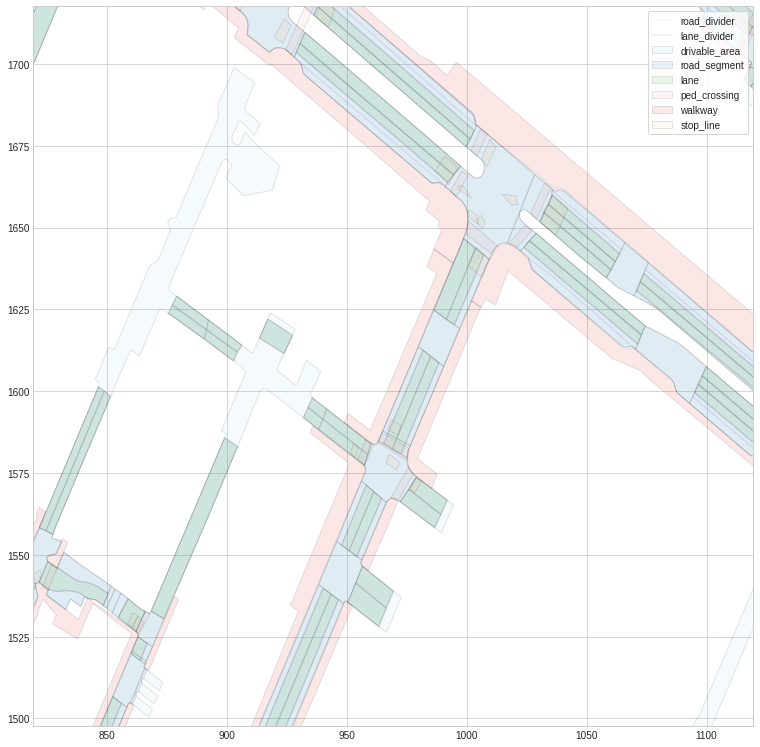

In [7]:
node = v_nodes[0]
print("Map centered on node", node)

layers = ['drivable_area',
          'road_segment',
          'lane',
          'ped_crossing',
          'walkway',
          'stop_line',
          'road_divider',
          'lane_divider']

ego_lastpos = histories_dict[t][node][-1]
ego_lastx = ego_lastpos[0]
ego_lasty = ego_lastpos[1]
center = (
    scene.ego_initx + ego_lastx,
    scene.ego_inity + ego_lasty)
viewport_hw = 100

my_patch = (center[0] - viewport_hw, center[1] - viewport_hw,
            center[0] + viewport_hw, center[1] + viewport_hw)

fig, ax = nusc_map.render_map_patch(my_patch, layers, figsize=(10, 10), alpha=0.1, render_egoposes_range=False)
fig.show()

### Combining forecast and map

In [26]:
# doesn't work?
scenes_to_use = ['14']
sel_scenes = list(filter(lambda s : s.name in scenes_to_use, eval_scenes))
scene = sel_scenes[0]

Vehicles [VEHICLE/ego, VEHICLE/1d95a89e0f284f92a754704003ade0aa]
Map centered on node VEHICLE/ego


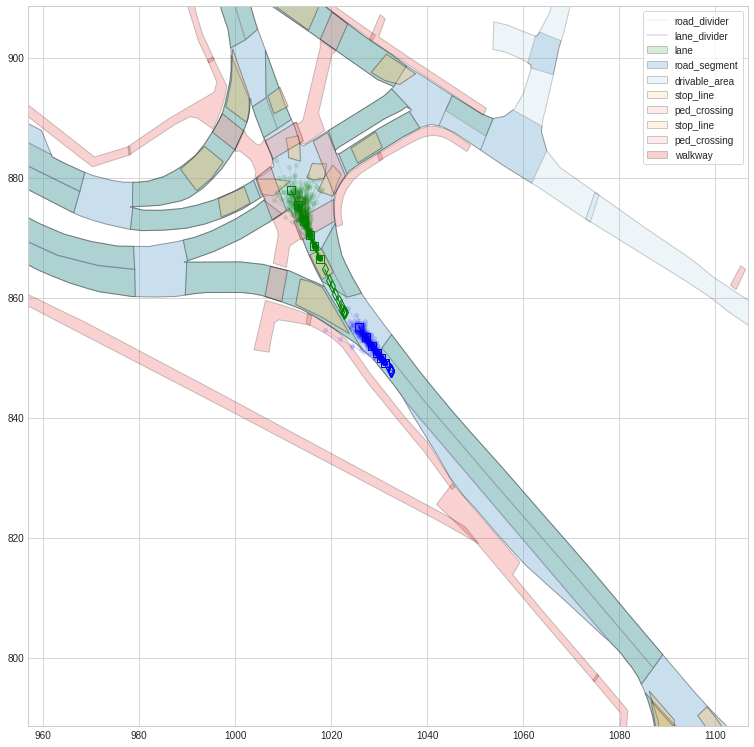

In [28]:
# scene = eval_scenes[14]
ph = 6
num_samples = 100
t = 12
timesteps = np.array([t])

with torch.no_grad():
    predictions = eval_stg.predict(scene,
            timesteps, ph, num_samples=num_samples,
                z_mode=False,
                gmm_mode=False,
                full_dist=False,
                all_z_sep=False)

prediction_dict, histories_dict, futures_dict = \
    prediction_output_to_trajectories(
        predictions, dt=scene.dt, max_h=10, ph=ph, map=None)

v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[t].keys()))
v_nodes.sort(key=lambda k: 0 if 'ego' in repr(k) else 1)
# node = next(filter(lambda k: 'ego' in repr(k), v_nodes))
node = v_nodes[0]

print("Vehicles", v_nodes)
print("Map centered on node", node)

minpos = np.array([scene.x_min, scene.y_min])
ego_lastpos = histories_dict[t][node][-1]
ego_lastx = ego_lastpos[0]
ego_lasty = ego_lastpos[1]
center = np.array([
    scene.ego_initx + ego_lastx,
    scene.ego_inity + ego_lasty])

center = minpos + ego_lastpos
viewport_hw = 50
my_patch = (center[0] - viewport_hw, center[1] - viewport_hw,
            center[0] + viewport_hw, center[1] + viewport_hw)
if scene.map_name != nusc_map.map_name:
    nusc_map = NuScenesMap(dataroot=nuScenes_data_path, map_name=scene.map_name)
fig, ax = nusc_map.render_map_patch(my_patch, scene.layer_names,
        figsize=(10, 10), alpha=0.2, render_egoposes_range=False)
# fig, ax = plt.subplot

# plt.figure(figsize=(8, 8), dpi=80)
for idx, node in enumerate(v_nodes):
    player_future = futures_dict[t][node]
    player_past = histories_dict[t][node]
    player_predict = prediction_dict[t][node]
    player_future += minpos
    player_past += minpos
    player_predict += minpos

    ax.plot(player_future[:,0], player_future[:,1],
                marker='s', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    ax.plot(player_past[:,0], player_past[:,1],
                marker='d', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    for row in player_predict[0]:
        ax.plot(row[:,0], row[:,1],
                marker='o', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, alpha=0.1, markersize=4)